# Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [1]:
import joblib

(A, terms, snippets) = joblib.load("21cenario2-tweets-tfidf.pkl")

print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 266214 X 12137 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [2]:
kmin, kmax = 5, 20

Apply NMF for each of these values:

In [3]:
from sklearn import decomposition

topic_models = []

# try each value of k
for k in [5,10,15,20]: #range(kmin, kmax + 1):
    print("Applying NMF for k=%d ..." % k)
    # run NMF
    model = decomposition.NMF(init="nndsvd", n_components=k)
    W = model.fit_transform(A)
    H = model.components_
    # store for later
    topic_models.append((k, W, H))

Applying NMF for k=5 ...
Applying NMF for k=10 ...
Applying NMF for k=15 ...
Applying NMF for k=20 ...


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

**Note:** If you want to skip this step, a pre-built Word2Vec model for the sample dataset [is also provided here for download](http://erdos.ucd.ie/files/pydata/w2v-model.bin) (71MB).

We read the documents from the input file again:

In [4]:
import os.path

raw_documents = []

with open(os.path.join("cenario2_8M2021_tweets_es.txt"), "r") as fin:
    for line in fin.readlines():
        raw_documents.append(line.strip().lower())

print("Read %d raw text documents" % len(raw_documents))

Read 266214 raw text documents


Read the custom stopword list:

In [5]:
custom_stop_words = []

with open("spanish.txt", "r") as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 313 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [6]:
import re


class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append(tok)
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [7]:
import gensim

In [8]:


docgen = TokenGenerator(raw_documents, custom_stop_words)

# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [9]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 12238 terms


Save for later use, so that we do not need to rebuild it:

In [10]:
w2v_model.save("21cenario1_w2v-model.bin")

In [11]:
# To re-load this model, run
# w2v_model = gensim.models.Word2Vec.load("cenario1_w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [12]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [13]:
import numpy as np


def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index, :])[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    
    return top_terms

Now process each of the models for different values of *k*:

In [14]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.2660
K=10: Coherence=0.2665
K=15: Coherence=0.2745
K=20: Coherence=0.2773


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

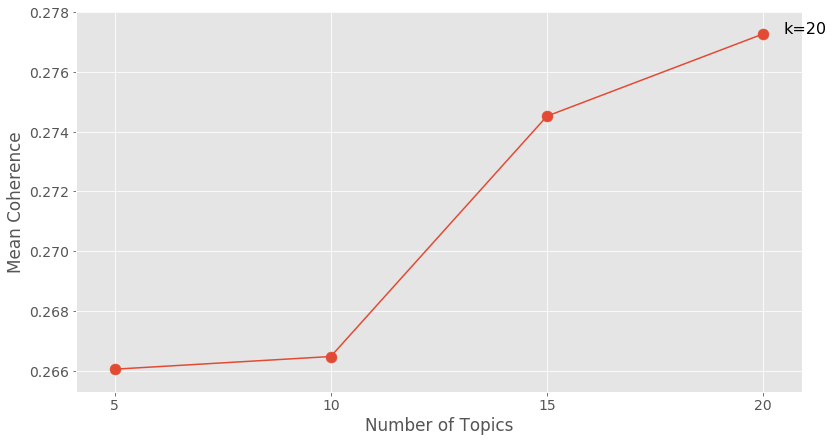

In [16]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

# 5

In [17]:
k = 5 # best_k

# get the model that we generated earlier.
W = topic_models[0][1]
H = topic_models[0][2]

In [18]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, feliz, falte, ninguna, cada
Topic 02: mujeres, igualdad, derechos, mundo, violencia
Topic 03: todas, gracias, felicidades, mundo, aquellas
Topic 04: hoy, lucha, siempre, dias, nunca
Topic 05: mujer, internacional, ser, dia, marzo


In [19]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, feliz, falte, ninguna, cada, algun, buen, celebrar, dejen, especial
Topic 02: mujeres, igualdad, derechos, mundo, violencia, hombres, lucha, genero, vida, sociedad
Topic 03: todas, gracias, felicidades, mundo, aquellas, voz, queremos, especial, companeras, quiero
Topic 04: hoy, lucha, siempre, dias, nunca, ano, igualdad, manana, solo, derechos
Topic 05: mujer, internacional, ser, dia, marzo, trabajadora, hombre, vida, igualdad, conmemoracion


In [20]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, feliz, falte, ninguna, cada, algun, buen, celebrar, dejen, especial, lucha, podamos, internacional, dias, decir
Topic 02: mujeres, igualdad, derechos, mundo, violencia, hombres, lucha, genero, vida, sociedad, asi, mexico, feminismo, pais, ninas
Topic 03: todas, gracias, felicidades, mundo, aquellas, voz, queremos, especial, companeras, quiero, muchas, cada, ustedes, luchan, juntas
Topic 04: hoy, lucha, siempre, dias, nunca, ano, igualdad, manana, solo, derechos, dia, conmemora, voz, queremos, conmemoramos
Topic 05: mujer, internacional, ser, dia, marzo, trabajadora, hombre, vida, igualdad, conmemoracion, sociedad, conmemora, derechos, mundo, cada


In [21]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, feliz, falte, ninguna, cada, algun, buen, celebrar, dejen, especial, lucha, podamos, internacional, dias, decir, mejor, celebracion, ojala, luchan, salir
Topic 02: mujeres, igualdad, derechos, mundo, violencia, hombres, lucha, genero, vida, sociedad, asi, mexico, feminismo, pais, ninas, trabajo, futuro, historia, solo, respeto
Topic 03: todas, gracias, felicidades, mundo, aquellas, voz, queremos, especial, companeras, quiero, muchas, cada, ustedes, luchan, juntas, amigas, hermanas, abrazo, luchando, vida
Topic 04: hoy, lucha, siempre, dias, nunca, ano, igualdad, manana, solo, derechos, dia, conmemora, voz, queremos, conmemoramos, ser, quiero, seguimos, miedo, feminista
Topic 05: mujer, internacional, ser, dia, marzo, trabajadora, hombre, vida, igualdad, conmemoracion, sociedad, conmemora, derechos, mundo, cada, violencia, genero, madre, historia, conmemoramos


# 10

In [22]:
k = 10 # best_k

# get the model that we generated earlier.
W = topic_models[1][1]
H = topic_models[1][2]

In [23]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, feliz, falte, cada, ninguna
Topic 02: mujeres, mundo, hombres, vida, violencia
Topic 03: todas, mundo, felicidades, aquellas, especial
Topic 04: hoy, dias, siempre, dia, manana
Topic 05: mujer, internacional, dia, marzo, trabajadora
Topic 06: ser, puede, debe, mujer, ninguna
Topic 07: lucha, feminista, derechos, sigue, conmemora
Topic 08: gracias, muchas, ultimo, disponible, siempre
Topic 09: miedo, asi, quiero, queremos, libres
Topic 10: igualdad, derechos, genero, violencia, respeto


In [24]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, feliz, falte, cada, ninguna, buen, algun, celebrar, dejen, dias
Topic 02: mujeres, mundo, hombres, vida, violencia, historia, ninas, trabajo, pais, mexico
Topic 03: todas, mundo, felicidades, aquellas, especial, luchan, voz, companeras, juntas, abrazo
Topic 04: hoy, dias, siempre, dia, manana, ano, voz, conmemora, nunca, conmemoramos
Topic 05: mujer, internacional, dia, marzo, trabajadora, conmemoracion, conmemora, hombre, vida, sociedad
Topic 06: ser, puede, debe, mujer, ninguna, falte, deberia, vida, hecho, parte
Topic 07: lucha, feminista, derechos, sigue, conmemora, viva, continua, conmemoramos, celebra, marzo
Topic 08: gracias, muchas, ultimo, disponible, siempre, tan, ustedes, mejor, gran, amo
Topic 09: miedo, asi, quiero, queremos, libres, solo, vivas, feminismo, nunca, marcha
Topic 10: igualdad, derechos, genero, violencia, respeto, oportunidades, sociedad, luchando, justicia, real


In [25]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, feliz, falte, cada, ninguna, buen, algun, celebrar, dejen, dias, especial, mejor, decir, podamos, buenos
Topic 02: mujeres, mundo, hombres, vida, violencia, historia, ninas, trabajo, pais, mexico, trabajadoras, trans, futuro, pandemia, igualitario
Topic 03: todas, mundo, felicidades, aquellas, especial, luchan, voz, companeras, juntas, abrazo, cada, ustedes, luchando, amigas, hermanas
Topic 04: hoy, dias, siempre, dia, manana, ano, voz, conmemora, nunca, conmemoramos, celebra, celebramos, marzo, buenos, solo
Topic 05: mujer, internacional, dia, marzo, trabajadora, conmemoracion, conmemora, hombre, vida, sociedad, mundo, marco, celebra, especial, historia
Topic 06: ser, puede, debe, mujer, ninguna, falte, deberia, vida, hecho, parte, dejen, quiero, orgullosa, libre, hombre
Topic 07: lucha, feminista, derechos, sigue, conmemora, viva, continua, conmemoramos, celebra, marzo, seguimos, sociedad, constante, companeras, dia
Topic 08: gracias, muchas, ultimo, disponible, siempr

In [26]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, feliz, falte, cada, ninguna, buen, algun, celebrar, dejen, dias, especial, mejor, decir, podamos, buenos, luchan, luchadoras, celebracion, guerreras, ojala
Topic 02: mujeres, mundo, hombres, vida, violencia, historia, ninas, trabajo, pais, mexico, trabajadoras, trans, futuro, pandemia, igualitario, derechos, marzo, parte, lideres, muchas
Topic 03: todas, mundo, felicidades, aquellas, especial, luchan, voz, companeras, juntas, abrazo, cada, ustedes, luchando, amigas, hermanas, respeto, queremos, vida, reconocimiento, faltan
Topic 04: hoy, dias, siempre, dia, manana, ano, voz, conmemora, nunca, conmemoramos, celebra, celebramos, marzo, buenos, solo, recordar, ayer, celebrar, felicita, buen
Topic 05: mujer, internacional, dia, marzo, trabajadora, conmemoracion, conmemora, hombre, vida, sociedad, mundo, marco, celebra, especial, historia, gran, conmemoramos, felicidades, participacion, cada
Topic 06: ser, puede, debe, mujer, ninguna, falte, deberia, vida, hecho, parte, dejen

# 15

In [27]:
k = 15 # best_k

# get the model that we generated earlier.
W = topic_models[2][1]
H = topic_models[2][2]

In [28]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, dejen
Topic 02: mujeres, hombres, vida, violencia, historia
Topic 03: todas, felicidades, aquellas, especial, voz
Topic 04: hoy, nunca, manana, voz, conmemora
Topic 05: mujer, internacional, marzo, trabajadora, hombre
Topic 06: ser, puede, debe, ninguna, solo
Topic 07: lucha, feminista, derechos, sigue, viva
Topic 08: gracias, muchas, ultimo, disponible, tan
Topic 09: dia, internacional, cada, celebrar, buen
Topic 10: igualdad, derechos, genero, violencia, respeto
Topic 11: asi, marcha, feminista, feminismo, gobierno
Topic 12: siempre, juntas, manana, fuertes, nunca
Topic 13: miedo, queremos, quiero, libres, vivas
Topic 14: dias, ano, buenos, solo, marzo
Topic 15: mundo, mejor, igualitario, futuro, justo


In [29]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, dejen, decir, companeras, deseamos, desea, luchadoras
Topic 02: mujeres, hombres, vida, violencia, historia, trabajo, trabajadoras, ninas, pais, derechos
Topic 03: todas, felicidades, aquellas, especial, voz, companeras, luchan, abrazo, amigas, juntas
Topic 04: hoy, nunca, manana, voz, conmemora, conmemoramos, celebra, celebramos, ayer, recordar
Topic 05: mujer, internacional, marzo, trabajadora, hombre, vida, sociedad, conmemora, conmemoracion, historia
Topic 06: ser, puede, debe, ninguna, solo, falte, deberia, vida, hecho, mujer
Topic 07: lucha, feminista, derechos, sigue, viva, conmemora, continua, conmemoramos, celebra, seguimos
Topic 08: gracias, muchas, ultimo, disponible, tan, ustedes, gran, amo, vida, trabajo
Topic 09: dia, internacional, cada, celebrar, buen, algun, conmemorar, conmemoracion, celebracion, especial
Topic 10: igualdad, derechos, genero, violencia, respeto, oportunidades, sociedad, justicia, luchando, real
Topic 11: asi, marc

In [30]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, dejen, decir, companeras, deseamos, desea, luchadoras, guerreras, chicas, matarnos, dice, mujer
Topic 02: mujeres, hombres, vida, violencia, historia, trabajo, trabajadoras, ninas, pais, derechos, trans, pandemia, mexico, valientes, muchas
Topic 03: todas, felicidades, aquellas, especial, voz, companeras, luchan, abrazo, amigas, juntas, ustedes, luchando, hermanas, cada, respeto
Topic 04: hoy, nunca, manana, voz, conmemora, conmemoramos, celebra, celebramos, ayer, recordar, aqui, felicita, celebrar, marzo, solo
Topic 05: mujer, internacional, marzo, trabajadora, hombre, vida, sociedad, conmemora, conmemoracion, historia, marco, participacion, primera, conmemoramos, madre
Topic 06: ser, puede, debe, ninguna, solo, falte, deberia, vida, hecho, mujer, parte, dejen, quiero, tan, hombre
Topic 07: lucha, feminista, derechos, sigue, viva, conmemora, continua, conmemoramos, celebra, seguimos, marzo, sociedad, constante, companeras, pie
Topic 08: gracias, m

In [31]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, falte, ninguna, dia, dejen, decir, companeras, deseamos, desea, luchadoras, guerreras, chicas, matarnos, dice, mujer, hermosas, happy, menos, lunes, deseo
Topic 02: mujeres, hombres, vida, violencia, historia, trabajo, trabajadoras, ninas, pais, derechos, trans, pandemia, mexico, valientes, muchas, parte, marzo, grandes, especial, sociedad
Topic 03: todas, felicidades, aquellas, especial, voz, companeras, luchan, abrazo, amigas, juntas, ustedes, luchando, hermanas, cada, respeto, vida, faltan, reconocimiento, justicia, tocan
Topic 04: hoy, nunca, manana, voz, conmemora, conmemoramos, celebra, celebramos, ayer, recordar, aqui, felicita, celebrar, marzo, solo, seguimos, aquellas, anos, recordamos, luchando
Topic 05: mujer, internacional, marzo, trabajadora, hombre, vida, sociedad, conmemora, conmemoracion, historia, marco, participacion, primera, conmemoramos, madre, motivo, fuerte, gran, papel, celebra
Topic 06: ser, puede, debe, ninguna, solo, falte, deberia, vida, hec

# 20

In [32]:
k = 20 # best_k

# get the model that we generated earlier.
W = topic_models[3][1]
H = topic_models[3][2]

Display the topic descriptors for this model:

In [33]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, celebrar, buen
Topic 02: mujeres, hombres, vida, historia, trabajo
Topic 03: todas, felicidades, aquellas, especial, voz
Topic 04: hoy, nunca, manana, voz, conmemora
Topic 05: mujer, internacional, marzo, trabajadora, hombre
Topic 06: ser, puede, debe, ninguna, falte
Topic 07: lucha, sigue, viva, conmemora, continua
Topic 08: gracias, muchas, ultimo, disponible, tan
Topic 09: feliz, falte, ninguna, dia, dejen
Topic 10: igualdad, respeto, hombres, oportunidades, real
Topic 11: feminismo, nunca, machismo, solo, hombre
Topic 12: siempre, juntas, manana, fuertes, ustedes
Topic 13: miedo, quiero, salir, vivir, calle
Topic 14: dias, buenos, ano, solo, marzo
Topic 15: mundo, mejor, igualitario, futuro, justo
Topic 16: asi, ojala, aun, cosas, bien
Topic 17: violencia, genero, vida, libre, machista
Topic 18: queremos, vivas, libres, iguales, fuertes
Topic 19: feminista, marcha, gobierno, aqui, palacio
Topic 20: derechos, luchando, humanos, seguir, oportunidad

In [34]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, celebrar, buen, algun, conmemoracion, conmemorar, celebracion, especial
Topic 02: mujeres, hombres, vida, historia, trabajo, trabajadoras, pais, ninas, trans, valientes
Topic 03: todas, felicidades, aquellas, especial, voz, companeras, luchan, abrazo, juntas, amigas
Topic 04: hoy, nunca, manana, voz, conmemora, conmemoramos, celebra, celebramos, ayer, recordar
Topic 05: mujer, internacional, marzo, trabajadora, hombre, vida, sociedad, conmemora, conmemoracion, historia
Topic 06: ser, puede, debe, ninguna, falte, deberia, solo, hecho, mujer, dejen
Topic 07: lucha, sigue, viva, conmemora, continua, conmemoramos, sociedad, celebra, marzo, constante
Topic 08: gracias, muchas, ultimo, disponible, tan, ustedes, gran, amo, vida, trabajo
Topic 09: feliz, falte, ninguna, dia, dejen, companeras, decir, deseamos, desea, luchadoras
Topic 10: igualdad, respeto, hombres, oportunidades, real, sociedad, genero, libertad, justicia, compromiso
Topic 11: feminismo, nun

In [35]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, celebrar, buen, algun, conmemoracion, conmemorar, celebracion, especial, recordar, marzo, luchan, felicitar, ojala
Topic 02: mujeres, hombres, vida, historia, trabajo, trabajadoras, pais, ninas, trans, valientes, muchas, pandemia, grandes, marzo, especial
Topic 03: todas, felicidades, aquellas, especial, voz, companeras, luchan, abrazo, juntas, amigas, ustedes, cada, hermanas, respeto, luchando
Topic 04: hoy, nunca, manana, voz, conmemora, conmemoramos, celebra, celebramos, ayer, recordar, felicita, celebrar, marzo, solo, aqui
Topic 05: mujer, internacional, marzo, trabajadora, hombre, vida, sociedad, conmemora, conmemoracion, historia, participacion, marco, primera, madre, conmemoramos
Topic 06: ser, puede, debe, ninguna, falte, deberia, solo, hecho, mujer, dejen, parte, tan, orgullosa, vida, hombre
Topic 07: lucha, sigue, viva, conmemora, continua, conmemoramos, sociedad, celebra, marzo, constante, seguimos, companeras, pie, felicita, equidad
Topic

In [36]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: dia, internacional, cada, celebrar, buen, algun, conmemoracion, conmemorar, celebracion, especial, recordar, marzo, luchan, felicitar, ojala, mejor, tan, importante, reflexion, luchar
Topic 02: mujeres, hombres, vida, historia, trabajo, trabajadoras, pais, ninas, trans, valientes, muchas, pandemia, grandes, marzo, especial, sociedad, parte, mexico, solo, homenaje
Topic 03: todas, felicidades, aquellas, especial, voz, companeras, luchan, abrazo, juntas, amigas, ustedes, cada, hermanas, respeto, luchando, justicia, vida, faltan, reconocimiento, tocan
Topic 04: hoy, nunca, manana, voz, conmemora, conmemoramos, celebra, celebramos, ayer, recordar, felicita, celebrar, marzo, solo, aqui, aquellas, anos, recordamos, seguimos, pueden
Topic 05: mujer, internacional, marzo, trabajadora, hombre, vida, sociedad, conmemora, conmemoracion, historia, participacion, marco, primera, madre, conmemoramos, fuerte, motivo, papel, gran, celebra
Topic 06: ser, puede, debe, ninguna, falte, deberia, 